<a href="https://colab.research.google.com/github/Himanshu5iiser/reinforcement_learning/blob/main/RL_robot_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot Moving in a Grid

Consider the following $5 \times 10$ grid in which a robot needs to move from $S$ to $T$. From any cell, the robot can <i>attempt</i> to take any of the 4 actions: <tt>left</tt>, <tt>up</tt>, <tt>right</tt> and <tt>down</tt>. The environment behaves as follows:
* Some actions will make the robot hit the wall (the bold line), so such actions will waste 1 unit of energy ($-1$ reward) and keep the robot in the same position. For example, a <tt>left</tt> or <tt>down</tt> move from $S$ will keep it in $S$ and earn reward $-1$ without any so called progress.
* The cells marked in red are muddy, so if the robot moves to any of those cells, then it earns reward $-20$.
* In all other cases, it loses 1 unit of energy (reward $-1$) and moves to another cell, as evident from the picture.

![grid-2.png](https://github.com/Himanshu5iiser/reinforcement_learning/blob/main/grid.png?raw=true)

The cells are numbered 0 to 50, as in the picture, and will be referred by the indices 0 to 50. Let the actions (attempt to move) be defined as 'L','U','R' and 'D'. The following code cell defines the start (S) and the terminal (T) cells.

In [ ]:
import numpy as np

S = 0 # index of start state
T = 9 # index of terminal state
n = 50 # number of states

## Task 1:  The dynamics of the environment

Write a function which returns the probability $p(s1,r|s,a)$ of moving to state $s1$ and getting reward $r$ when the robot takes action $a$ from state $s$. You may define the dynamics in a tensor and simply return the appropriate element, or you may write a function that calculates the probability (because the grid has a pattern).

In [ ]:
def p(s1,r,s,a):
    if s == T:
        return 0 # The episode has ended
    else:
      move={"L": -1,
            "U":10,
            "R":1,
            "D":-10}
      boundary={"L":(s//10)*10,"R":(s//10)*10+9,"D":s%10,"U":s%10+40}
      stemp=s+move[a]
      if a in ["R", "U"]:
        stemp=min(stemp,boundary[a])

      else:
        stemp=max(stemp,boundary[a])
      if stemp in list(range(1,9)):
        if r==-20:
          return float(stemp==s1)
        else:
          return 0.0
      else:
        if r==-1:
          return float(stemp==s1)
        else:
          return 0.0


    # Complete your code here and return appropriately
    #return 1

In [ ]:
# Test cases
assert(p(40,-1,40,'L')==1), "From 40, going left will not work."
assert(p(33,-1,34,'D')==0), "From 33, 'D' will take you to 23."

## Task 2: The Value function $v_*$ under the Optimal Policy $\pi_*$

From the picture, the optimal path from $S$ to $T$ is clear. However, note that the optimal policy is defined for any state, i.e., even if the robot is in some state not in the optimal path from $S$ to $T$, it has an optimal policy to follow. Under the optimal policy $\pi_*$, every state has $s$ a value function $v_*(s)$. Manually or programmatically compute the array $v_*$ of size 50.

In [ ]:
def v_star(p,n,S,T):
    v = np.zeros(n)
    ## Complete your code
    if T in range(1,9):
        v[0]=-(abs(10%10-T%10)+abs(10//10-T//10)+20)
        for i in range(1,50):
            if i==T-1:
                v[i]=-20
#             elif i==T:
#                 v[i]=0
            elif i in range(1,9):
                i0=i+10
                v[i]=-(abs(i0%10-T%10)+abs(i0//10-T//10)+20)
            else:
                v[i]=-(abs(i%10-T%10)+abs(i//10-T//10)-1+20)
    elif T==9:
        v[8]=-1
        for i in range(50):
            if i!=8:
                if i in range(10):
                    i0=i+10
                    v[i]=-(abs(i0%10-T%10)+abs(i0//10-T//10)+1)
                else:
                    v[i]=-(abs(i%10-T%10)+abs(i//10-T//10))
    elif T==0:
        v[1]=-1
        for i in range(50):
            if i!=1:
                if i in range(10):
                    i0=i+10
                    v[i]=-(abs(i0%10-T%10)+abs(i0//10-T//10)+1)
                else:
                    v[i]=-(abs(i%10-T%10)+abs(i//10-T//10))



    else:

        #v[0]=-(abs(10%10-T%10)+abs(10//10-T//10)+1)
        for i in range(50):
            if i in range(10):
                i0=i+10
                v[i]=-(abs(i0%10-T%10)+abs(i0//10-T//10)+1)
            else:
                v[i]=-(abs(i%10-T%10)+abs(i//10-T//10))
    v[T]=0

    return np.array(v)
    return v

In [ ]:
v_star([],50,0,9)

array([-11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -1.,   0., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.])

In [ ]:
assert(v_star(p).shape==(n,))

TypeError: ignored

## Task 3: DP Value Iteration

Implement the dynamic programming based value iteration algorithm (Sutton and Barto, Page 83) to return an optimal policy $\pi_*$ for the problem. Note that in this case, the agent can use the dynamics $p$ of the environment. Instead of looping forever, your function should continue learning till $N$ steps (or when the policy converges, whichever is earlier), where $N$ is being passed as a parameter.

For you to analyze the performance of the algorithm, also store the total reward for every episode in an array (<tt>rewards</tt>) and return that array along with the optimal policy. Note that, once the policy is optimal, an episode following the optimal policy will have an optimal reward.

In [ ]:
"""
    paramters:
        p: the dynamics (actually a function defined earlier)
        n: the number of states
        S: the index of the start state
        T: the index of the terminal state
        N: maximum number of steps / actions
"""
def value_iteration(p,n,S,T,N):
    v = np.zeros(n)
    pi = [0 for i in range(n)]#np.zeros(n, dtype=int)  # Policy
    rewards = np.array([0 for i in range(N)])

    gamma = 0.9  # Discount factor

    for i in range(N):
        delta = 0
        tr=0
        for s in range(n):
            if s == T:
                continue

            v_old = v[s]
            max_value = -np.inf
            best_action = None

            for a in ['L', 'U', 'R', 'D']:
                expected_value = 0
                for s1 in range(n):
                    for r in [-20, -1]:
                        transition_prob = p(s1, r, s, a)
                        expected_value += transition_prob * (r + gamma * v[s1])
                if expected_value > max_value:
                    max_value = expected_value
                    best_action = a
            tr+=max_value
            v[s] = max_value
            pi[s] = best_action
            delta = max(delta, abs(v_old - v[s]))
        rewards[i]+=tr


        # if delta < 1e-6:
        #     break

    return pi, rewards/N

In [ ]:
a,b=value_iteration(p,n,S,T,100)
len(b),v_star([],50,0,9)

(100,
 array([-11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -1.,   0., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3., -13., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.]))

## Task 4: SARSA (on-policy TD control)

Implement on-policy TD control (Sutton and Barto, Page 130) for the above problem and compute the optimal action values $q_*$ for every state action pair and return the optimal policy learnt in the process. Note that in this case the dynamics of the environment is passed to the function, but that's only for computing the state and reward after every action. The agent should not use $p$ directly. Similar to Task 3, store the rewards and return.

In [ ]:
def sarsa(p, n, S, T, N, alpha, epsilon):
    pi = [0 for i in range(n)]#np.zeros(n, dtype=int)  # Policy
    rewards = np.array([0 for i in range(N)])
    #Q={key: value for key, value in Qinit.items()}

    Q={"L":-np.ones(50),"R":-np.ones(50), "U":-np.ones(50), "D":-np.ones(50)}
    Q["R"][:8]=-20
    Q["R"][8]=-1
    Q["L"][2:9]=-20
    Q["L"][:2]=-1
    Q["D"][11:19]=-20

    gamma = 1  # Discount factor

    for i in range(N):
        s = S

        #print(a)
        episode_reward = 0

        for _ in range(N):
            actions=["L","U","R","D"]
            qt=[Q["L"][s],Q["U"][s],Q["R"][s],Q["D"][s]]
            a = actions[qt.index(max(qt))] if np.random.rand() > epsilon else np.random.choice(actions)

            if s == T:
                continue #return 0
            move={"L": -1,
                "U":10,
                "R":1,
                "D":-10}
            boundary={"L":(s//10)*10,"R":(s//10)*10+9,"D":s%10,"U":s%10+40}
            s1=s+move[a]
            if a in ["R", "U"]:
                s1=min(s1,boundary[a])

            else:
                s1=max(s1,boundary[a])
            r=-20 if s1 in range(1,9) else -1

            #finding max Q
            qt=[Q["L"][s1],Q["U"][s1],Q["R"][s1],Q["D"][s1]]
            amax = actions[qt.index(max(qt))]

            #a1 = pi[s1] if np.random.rand() > epsilon else np.random.choice([0, 1, 2, 3])
            Q[a][s]=Q[a][s]+alpha*(r+gamma*Q[amax][s1]-Q[a][s])
            rewards[i]+=r
            s=s1
            #pi[s] = np.argmax(Q["L" if s in [1, 2, 3, 4, 5, 6, 7, 8] else "R"][:8][s])

            # episode_reward += r
            # s = s1
            a = amax

            if s == T:
                break

        #rewards.append(episode_reward)
    for i in range(n):
        actions=["L","U","R","D"]
        qt=[Q["L"][i],Q["U"][i],Q["R"][i],Q["D"][i]]
        pi[i] = actions[qt.index(max(qt))]
    return pi, rewards/N


In [ ]:
a,b=sarsa(p,n,0,T,1000,0.2,0.1)
len(b),a

(1000,
 ['U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'R',
  'L',
  'R',
  'R',
  'R',
  'R',
  'R',
  'R',
  'R',
  'R',
  'R',
  'D',
  'L',
  'D',
  'R',
  'R',
  'R',
  'R',
  'R',
  'D',
  'R',
  'D',
  'U',
  'L',
  'R',
  'R',
  'R',
  'R',
  'R',
  'D',
  'R',
  'D',
  'L',
  'R',
  'R',
  'D',
  'R',
  'U',
  'D',
  'R',
  'R',
  'L'])

## Task 5: Q-Learning (off-policy TD control)

Similar to Task 4, implement the off-policy TD control (Sutton and Barto, Page 131). Since this algorithm is off-policy, the behavior policy is not expected to gain good rewards for every episode. Nevertheless, return the rewards as before.

In [ ]:
def q_learning(p,n,S,T,N,alpha,epsilon):
    pi = [0 for i in range(n)]#np.zeros(n, dtype=int)  # Policy
    rewards = np.array([0 for i in range(N)])
    #Q={key: value for key, value in Qinit.items()}

    Q={"L":-np.ones(50),"R":-np.ones(50), "U":-np.ones(50), "D":-np.ones(50)}
    Q["R"][:8]=-20
    Q["R"][8]=-1
    Q["L"][2:9]=-20
    Q["L"][:2]=-1
    Q["D"][11:19]=-20

    gamma = 1  # Discount factor

    for i in range(N):
        s = S

        #print(a)
        episode_reward = 0

        for _ in range(N):
            actions=["L","U","R","D"]
            qt=[Q["L"][s],Q["U"][s],Q["R"][s],Q["D"][s]]
            a = actions[qt.index(max(qt))] if np.random.rand() > epsilon else np.random.choice(actions)

            if s == T:
                continue #return 0
            move={"L": -1,
                "U":10,
                "R":1,
                "D":-10}
            boundary={"L":(s//10)*10,"R":(s//10)*10+9,"D":s%10,"U":s%10+40}
            s1=s+move[a]
            if a in ["R", "U"]:
                s1=min(s1,boundary[a])

            else:
                s1=max(s1,boundary[a])
            r=-20 if s1 in range(1,9) else -1

            #finding max Q
            qt=[Q["L"][s1],Q["U"][s1],Q["R"][s1],Q["D"][s1]]
            amax = actions[qt.index(max(qt))]

            #a1 = pi[s1] if np.random.rand() > epsilon else np.random.choice([0, 1, 2, 3])
            Q[a][s]=Q[a][s]+alpha*(r+gamma*Q[amax][s1]-Q[a][s])
            rewards[i]+=r
            s=s1
            #pi[s] = np.argmax(Q["L" if s in [1, 2, 3, 4, 5, 6, 7, 8] else "R"][:8][s])

            # episode_reward += r
            # s = s1
            #a = amax

            if s == T:
                break

        #rewards.append(episode_reward)
    for i in range(n):
        actions=["L","U","R","D"]
        qt=[Q["L"][i],Q["U"][i],Q["R"][i],Q["D"][i]]
        pi[i] = actions[qt.index(max(qt))]
    return pi, rewards/N


In [ ]:
q_learning(p,n,S,T,100,0.2,0.1)

(['U',
  'L',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'R',
  'L',
  'R',
  'U',
  'U',
  'R',
  'R',
  'R',
  'R',
  'R',
  'R',
  'D',
  'R',
  'R',
  'L',
  'R',
  'D',
  'R',
  'R',
  'R',
  'D',
  'D',
  'L',
  'L',
  'U',
  'R',
  'L',
  'U',
  'R',
  'R',
  'D',
  'D',
  'R',
  'U',
  'L',
  'R',
  'R',
  'R',
  'U',
  'U',
  'D',
  'U'],
 array([-1.  , -1.19, -1.38, -1.  , -0.78, -1.19, -0.56, -1.19, -1.  ,
        -0.87, -1.  , -1.38, -0.97, -1.35, -1.  , -1.  , -0.57, -0.59,
        -0.69, -0.82, -1.  , -0.38, -0.94, -0.33, -1.38, -0.74, -0.45,
        -0.78, -0.64, -0.52, -1.  , -0.44, -0.85, -0.6 , -0.47, -1.17,
        -0.62, -0.36, -0.27, -1.76, -0.57, -0.45, -0.31, -0.58, -0.6 ,
        -0.74, -0.4 , -0.54, -0.39, -0.22, -0.28, -0.45, -0.62, -0.36,
        -0.4 , -0.33, -0.36, -0.15, -0.52, -0.46, -0.63, -0.86, -0.32,
        -0.26, -0.19, -0.73, -0.39, -0.32, -0.34, -0.49, -0.32, -0.22,
        -0.69, -0.73, -0.3 , -0.39, -0.42, -0.27, -0.42, -0.21, -0.4 ,
        -0

## Task 6: Compare the methods

Compare the methods in terms of
* How fast they converge to an optimal policy (if at all)
* Whether the method is aggressive or conservative (Refer to the discussion in Page 132)
* Rewards per episodes during the learning, etc

with appropriate visual plots.

In [ ]:
import matplotlib.pyplot as plt

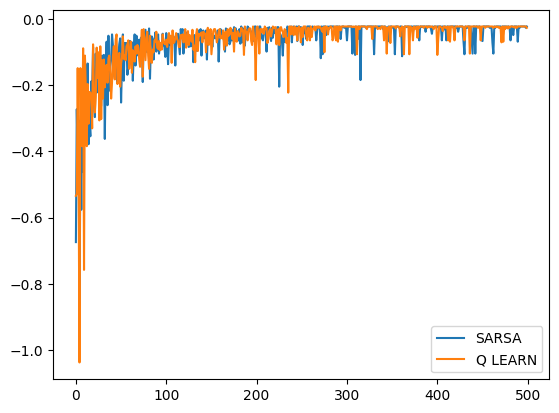

In [ ]:
# No fixed guideline, do as you feel
a,b=value_iteration(p,n,S,T,50)
c,d=sarsa(p,n,0,T,500,0.1,0.05)
e,f=q_learning(p,n,S,T,500,0.1,0.05)
#plt.plot(b,label="DP")
plt.plot(d,label="SARSA")
plt.plot(f,label="Q LEARN")
plt.legend()
plt.show()
#print(f)





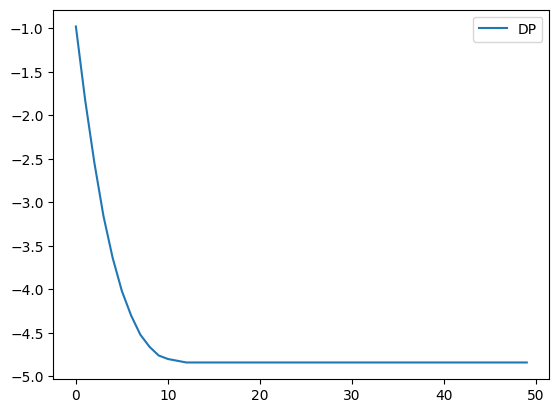

In [ ]:
#For DP
plt.plot(b,label="DP")
plt.legend()
plt.show()

We observe that DP converges way faster than other 2 algorithms as it converged in nearly 10 episodes whereas q-learning and sarsa perform almost similar for this example and take about 200 episodes to converge to a solution.

**Path plotting**

In [ ]:
symbol={"L":"←","R":"→","U":"↑","D":"↓",0:"✙"}

In [ ]:
def plotpath(arr):
    ans=[]
    #temp=[]
    for i in range(len(arr)):
        if i%10==0:
            temp=[]
            ans.append(temp)
            temp.append(symbol[arr[i]])
            #temp=[]
            continue
        temp.append(symbol[arr[i]])
        #print(,end="")
    #print(ans)
    for i in range(len(ans)):
        print(*ans[-(i+1)])


Path for DP

In [ ]:
plotpath(a)

→ → → → → → → → → ↓
→ → → → → → → → → ↓
→ → → → → → → → → ↓
→ → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → ✙


Path for SARSA

In [ ]:
plotpath(c)

↓ → ↓ → → → ↓ ↓ → ↓
← → → ↑ → ↓ ↓ → ↓ ↓
↑ ← → → → → → ↓ ↓ ↓
→ → → → → → → → → ↓
↑ ↑ ↓ ↑ ↑ ↑ ↑ ↓ → ←


Path for Q-Learning

In [ ]:
plotpath(e)

↓ ↑ → → ↓ → ↓ ↓ → →
↑ → → → ← ← ← → → ↓
→ → → → → → ↓ → → ↓
→ → → → → → → → → ↓
↑ ↑ ↓ ↑ ↑ ↑ ↓ ↑ ↑ ←
